Dataset loader, preprocess

Label Mapping: {'+': 0, '-': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, '=': 12, 'x': 13, 'y': 14, 'extra_15': 15, 'extra_16': 16, 'extra_17': 17, 'extra_18': 18, 'extra_19': 19, 'extra_20': 20, 'extra_21': 21, 'extra_22': 22, 'extra_23': 23, 'extra_24': 24, 'extra_25': 25, 'extra_26': 26, 'extra_27': 27, 'extra_28': 28, 'extra_29': 29}
Training set size: 59401
Validation set size: 12728
Test set size: 12730


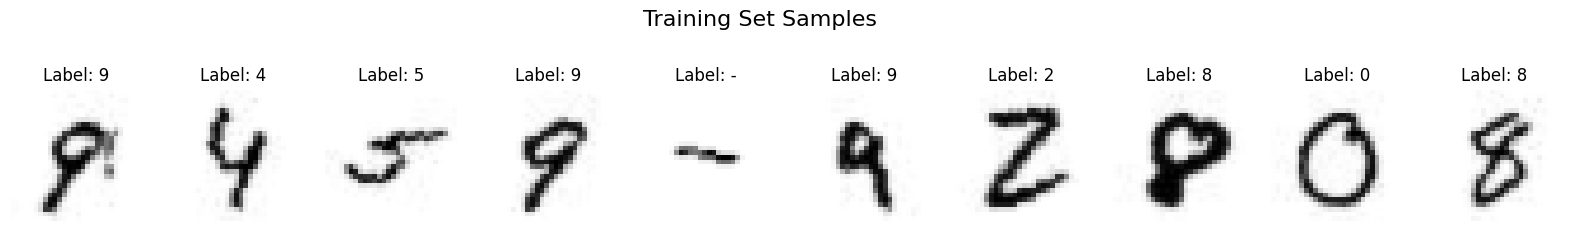

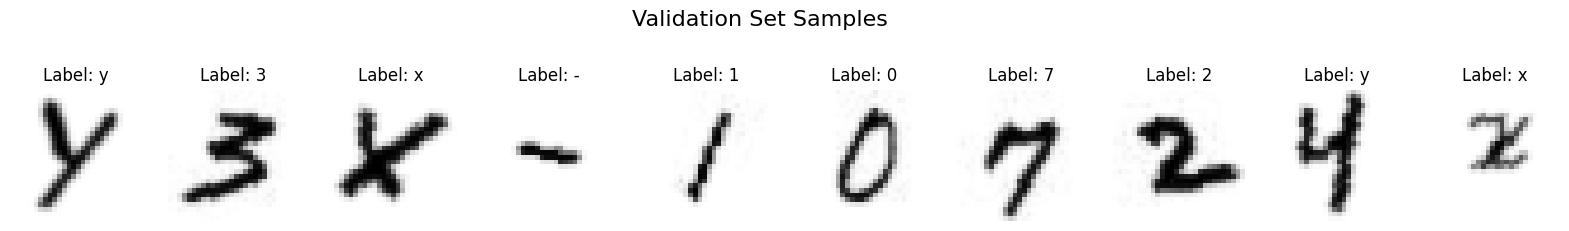

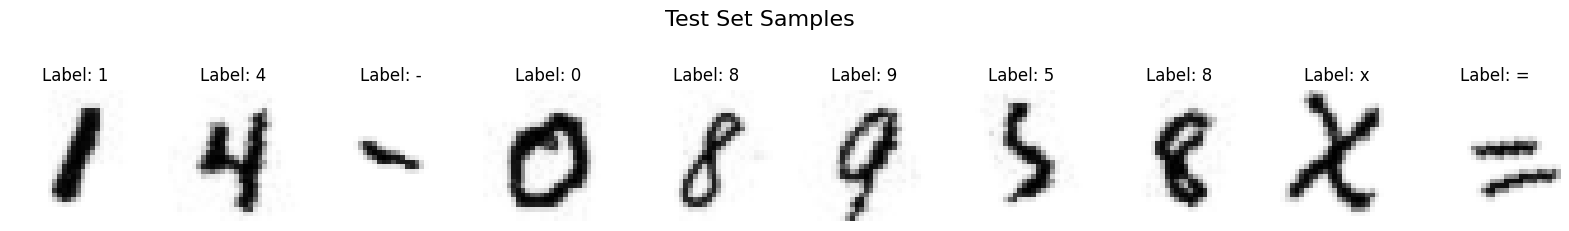

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.RandomRotation(degrees=20),
    transforms.RandomInvert(p=1.0),  # Invert colors (white to black, black to white)
    transforms.GaussianBlur(kernel_size=5, sigma=0.5),  # Reduce noise while preserving edges
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0, std 1
])

# Path to dataset (update with your actual dataset folder path)
dataset_path = "<path_to_set>"

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)
# Create a mapping from index to character
int_to_char = {v: k for k, v in dataset.class_to_idx.items()}

# Handle special case for division symbol in int_to_char
for idx, char in int_to_char.items():
    if char == 'div':
        int_to_char[idx] = '/'

# Create a mapping for labels
# Get the original mapping from the dataset
label_mapping = dataset.class_to_idx

# Handle special case for division symbol
if 'div' in label_mapping:
    # If the folder name is 'div', map it to '/'
    label_mapping['/'] = label_mapping.pop('div')

# Ensure we have digits 0-9 in the mapping
for i in range(10):
    if str(i) not in label_mapping:
        label_mapping[str(i)] = len(label_mapping)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Remaining samples for test set

torch.manual_seed(42)
# Split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Print the number of items in each split
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Function to display 10 samples from any DataLoader
def show_samples(dataloader, title="Samples", dataset=dataset):
    class_names = dataset.classes  # Get the class names from ImageFolder
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f"Label: {class_names[labels[i]]}")  # Map the numeric label to the class name
        ax.axis('off')
    plt.show()

# Show samples from each set
show_samples(train_loader, "Training Set Samples")
show_samples(val_loader, "Validation Set Samples")
show_samples(test_loader, "Test Set Samples")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.quantization as quant

# Define Custom_CNN model
class Custom_CNN(nn.Module):
    def __init__(self, num_classes=30):  # Adjust according to your dataset
        super(Custom_CNN, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()  # QuantStub
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.dequant(x)
        return x

# Function to save the model and labels
def save_model_and_labels(model, filepath, labels_mapping):
    torch.save({
        'model_state_dict': model.state_dict(),
        'labels_mapping': labels_mapping
    }, filepath)
    print(f"Model and labels saved to {filepath}")

# Function to evaluate the model
def evaluate_model(model, dataloader, criterion, device, desc="Evaluating"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(dataloader, desc=desc)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Training and validation loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc="Training")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # Evaluate on the validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, desc="Validating")

        # Print metrics
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Log metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Step the scheduler
        scheduler.step()

    pre_quant_model_path = 'model_pre_quant.pth'
    save_model_and_labels(model, pre_quant_model_path, int_to_char)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Initialize and prepare the model
device = torch.device('cpu')
model = Custom_CNN(num_classes=15)
model.eval()

# Set quantization backend and QConfig
torch.backends.quantized.engine = 'x86'
custom_qconfig = quant.QConfig(
    activation=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver, quant_min=0, quant_max=255,
        dtype=torch.quint8, qscheme=torch.per_tensor_affine
    ),
    weight=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver, quant_min=-128, quant_max=127,
        dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
    )
)
model.qconfig = custom_qconfig

# Fuse and prepare for QAT
model_fused = torch.ao.quantization.fuse_modules(
    model, [['conv1', 'relu1'], ['conv2', 'relu2'], ['fc1', 'relu3']]
)
model_prepared = torch.ao.quantization.prepare_qat(model_fused.train(), inplace=True)
model_prepared.to(device)

# Define training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_prepared.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train and validate
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model_prepared, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

# Convert to quantized model
model_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_prepared)

# Evaluate the quantized model on the test set
test_loss, test_acc = evaluate_model(model_int8, test_loader, criterion, device, desc="Testing")
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Save the final quantized model with label mapping
final_model_path = 'model.pth'
# save_model_and_labels(model_int8, final_model_path, int_to_char)

# Plot training and validation metrics
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
save_model_and_labels(model_int8, final_model_path, int_to_char)